### Loading and extracting the data

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# load json files into a DataFrame
def load_json_data(folder_path):
    data_list = []
    files = [f for f in os.listdir(folder_path) if f.endswith(".json")]

    for file in files:
        file_path = os.path.join(folder_path, file)
        with open(file_path, 'r') as f:
            data = json.load(f)

        df = pd.DataFrame(data)
        df['id'] = file.split('.')[0]  # Extract ID from filename
     #    df['time'] = pd.to_datetime(df['time'])
        df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S.%f", errors='coerce')
        # Handle cases where microseconds are missing
        df["time"].fillna(pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S", errors='coerce'), inplace=True)
        df['side'] = df['metadata'].apply(lambda x: x['side'])  # Extract side info
        df.drop(columns=['metadata'], inplace=True)

        data_list.append(df)

    return pd.concat(data_list, ignore_index=True)

# Load data from the provided directory
folder_path = "../data/data_raw"
raw_df = load_json_data(folder_path)
df = raw_df.copy()

# to save the raw extracted data
path_to_save = os.path.join('../data', 'raw_extracted_data.csv')
raw_df.to_csv(path_to_save, index=False)

print('Success')
print("*"*30)




Success
******************************


In [69]:
df.shape

(2248628, 9)

In [70]:
df.head()

,time,ax,gz,gx,az,gy,ay,id,side
0,2024-06-14 12:20:22.332,0.052216,0.00,-0.42,-1.077016,3.01,0.028792,qOFuUi37Xw1hextwdqbQ,L
1,2024-06-14 12:20:22.334,0.054168,0.07,-0.49,-1.081896,2.73,0.025864,qOFuUi37Xw1hextwdqbQ,L
2,2024-06-14 12:20:22.336,0.053192,0.14,-0.28,-1.079944,2.73,0.028792,qOFuUi37Xw1hextwdqbQ,L
3,2024-06-14 12:20:22.339,0.052704,0.07,-0.35,-1.077016,2.73,0.027816,qOFuUi37Xw1hextwdqbQ,L
4,2024-06-14 12:20:22.341,0.049288,0.07,-0.42,-1.078480,2.80,0.024400,qOFuUi37Xw1hextwdqbQ,L


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2248628 entries, 0 to 2248627
Data columns (total 9 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   ax      float64       
 2   gz      float64       
 3   gx      float64       
 4   az      float64       
 5   gy      float64       
 6   ay      float64       
 7   id      object        
 8   side    object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 154.4+ MB


### Dealing with missing values

In [78]:
# Check for missing values
df.isnull().sum()
# df.isna().sum()

time    2230
ax         0
gz         0
gx         0
az         0
gy         0
ay         0
id         0
side       0
dtype: int64

### to handle the missing value:
Note: I need more context from domain expert or more knowledge of the device (sensors) to understand why the time were not recorded or the cause of the such disruption then i can make a better decision but the following is my blind assessment. <br><br>
since the missing values are randomly spotted in different places (most probably between sessions - every measurements). I can use ffill to deal with missing values. every timestamps are different from each other by either 2 milliseconds or three seconds on the average and worth to mention timestamps are missing randomly (saying looking at the indices) which is also convincing for using this approach

In [85]:
# temp_time = df["time"].astype("int64")  # Convert to nanoseconds (Pandas uses int64 (datetime64[ns]) timestamps)
# temp_time = temp_time.interpolate(method="linear")  # Perform interpolation
# df["time"] = pd.to_datetime(temp_time)  # Convert back to datetime

df["time"] = df["time"].fillna(method="ffill")


In [88]:
# df["time"].isna().sum()
df['time'].isnull().sum()
# df.isnull().sum()

0

### Setting up the timestamps as the index
it is the best practices in time-series or the data of such nature

In [93]:
df.set_index('time', inplace=True)
df = df.sort_index()

### Dealing with duplicated values

In [94]:
duplicated_columns = df.apply(lambda col: col.duplicated().sum())
duplicated_columns

ax      2225509
gz      2238097
gx      2236427
az      2230406
gy      2232034
ay      2237580
id      2248394
side    2248626
dtype: int64

As there are many duplicated values (column-wise) but I leave the way it is and here is why: <br>
time: the timestamp are so close that has a difference of milliseconds and some of had no milliseconds value so they are the same with some of subsequent values <br>
accelerometer and gyroscope values: such signals reading can be look a like <br>
id and side: of course they are supposed to be same based on the nature of our data


In [101]:
# Count of duplicated rows for each column
# duplicated_rows_per_column = df.duplicated(subset=df.columns).sum()
duplicated_rows_per_column = df.duplicated().sum()
print(f"Total number of duplicated rows: {duplicated_rows_per_column}")
print('*'*50)

print('after including the time')
# Reset the index to make time a column again
df_reset = df.reset_index()

# Check for duplicates after including the 'time' column
duplicated_after_time = df_reset.duplicated().sum()
print(f"Duplicated after including the time: {duplicated_after_time}")

Total number of duplicated rows: 498
**************************************************
after including the time
Duplicated after including the time: 0


As the nature of data is allowing duplicate in every columns so they could be duplicated (across the columns - intersection happens) but not when timestamp is included.

In [102]:
df.head()

,ax,gz,gx,az,gy,ay,id,side
time,,,,,,,,
2024-06-14 07:19:32.380,0.031720,-0.98,-0.84,-1.004792,0.42,0.063928,MRBF3DNuWq0zhSXajwPy,R
2024-06-14 07:19:32.382,0.032208,-1.05,-0.84,-1.007720,0.77,0.061488,MRBF3DNuWq0zhSXajwPy,R
2024-06-14 07:19:32.384,0.035136,-0.91,-0.91,-1.005768,0.28,0.060024,MRBF3DNuWq0zhSXajwPy,R
2024-06-14 07:19:32.387,0.034160,-0.98,-0.70,-1.003328,0.77,0.064416,MRBF3DNuWq0zhSXajwPy,R
2024-06-14 07:19:32.389,0.034648,-0.98,-0.91,-1.009672,0.14,0.058560,MRBF3DNuWq0zhSXajwPy,R


### Applying Normalization or Filter
in order to make this decision I need more context such as what are the units or scales of the sensor data (signals). Are the units in accelerometer and gyroscope are the same? for instance if one feature is in meters and another in kilograms or one is in meters and another is in centi meter. <br><br>
based on an article (see references), Min-Max scaling is recommended usually for sensor data so all the features are scaled between 0 and 1

In [105]:
df.describe()

,ax,gz,gx,az,gy,ay
count,2.248628e+06,2.248628e+06,2.248628e+06,2.248628e+06,2.248628e+06,2.248628e+06
mean,1.200217e-01,-2.658854e-01,-4.722534e-01,-1.272025e+00,2.483512e-01,3.753518e-03
std,9.159971e-01,4.039388e+01,4.766796e+01,6.964197e-01,1.790438e+02,2.816670e-01
min,-1.096097e+01,-2.137730e+03,-2.183790e+03,-1.597370e+01,-2.118900e+03,-1.101074e+01
25%,-3.172000e-02,-1.750000e+00,-3.220000e+00,-1.267336e+00,-1.400000e+00,-2.879200e-02
50%,1.464000e-02,-4.200000e-01,-4.200000e-01,-1.044808e+00,9.800000e-01,4.392000e-03
75%,8.052000e-02,7.700000e-01,2.940000e+00,-1.008208e+00,3.269000e+01,2.976800e-02
max,1.233908e+01,2.251620e+03,1.841770e+03,1.599030e+01,2.205980e+03,1.119521e+01


there are a lot of disparities in features. for example:<br><br>
Standard Deviation (std): <br>
The columns gz, gx, gy, and az have large standard deviations (gz has std = 40.39 and gy has std = 179.04), which suggests that these features have a large spread compared to others like ax and ay, which have much smaller standard deviations (ax with std = 0.92 and ay with std = 0.28).<br>

Given the disparities in standard deviation and range across columns, normalization is necessary dataset. It will help prevent any features with larger values from dominating and will make data more suitable for machine learning models.

<!-- # What is noise in sensor readings?
what are the criterial to classify a reading or readings as noise? -->

### Which Filter to Use ...(more context)? 
answer by chatgpt: <br>
The Low-Pass Butterworth Filter is a common choice because it has a smooth frequency response and does not introduce phase distortion, making it ideal for time-series sensor data. It works by allowing low-frequency components of the signal (which are likely to be the true signal) to pass through while filtering out high-frequency noise.

- Apply a Low-Pass Filter if your data shows high-frequency noise.
- The Butterworth Filter is a good option for sensor data because it provides a smooth frequency response and avoids phase distortion.

### Some visualization before applying filters and feature engineering
worth to mention:
the entire dataset spans from 07:19:32.380 to 13:03:10.196 on June 14, 2024, which is approximately 5 hours and 43 minutes (~20,218 seconds)

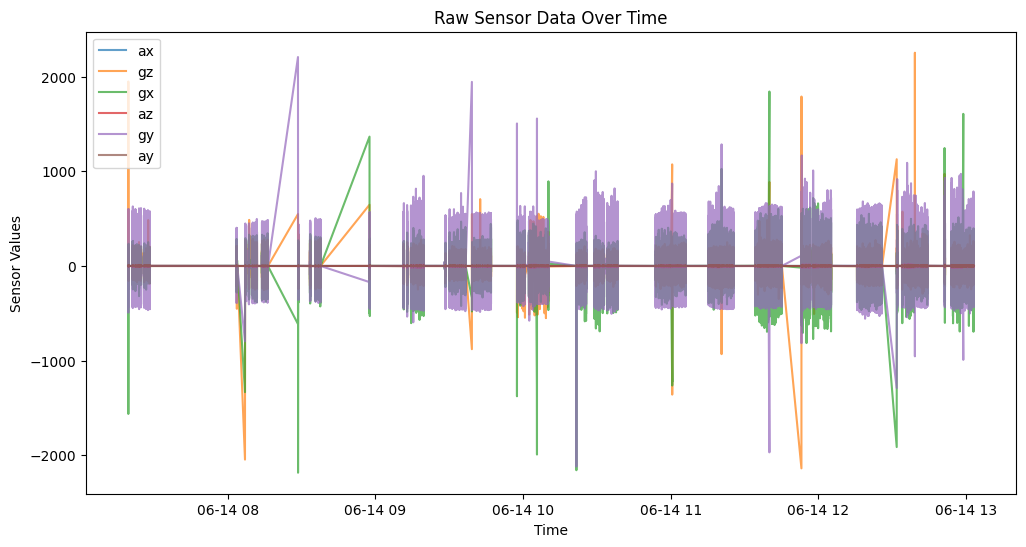

In [111]:
import matplotlib.pyplot as plt

# Plot multiple sensor values
columns_to_plot = ['ax', 'gz', 'gx', 'az', 'gy', 'ay']
plt.figure(figsize=(12, 6))

for col in columns_to_plot:
    plt.plot(df.index, df[col], label=col, alpha=0.7)  # Transparency for overlapping

plt.xlabel("Time")
plt.ylabel("Sensor Values")
plt.title("Raw Sensor Data Over Time")
plt.legend()
plt.show()


extreme fluctuations or sudden spikes in gx, gy and gz indicate noise

In [114]:
df['time_diff'] = df.index.to_series().diff().dt.total_seconds()
df['time_diff'].describe()  

count    2.248627e+06
mean     9.169069e-03
std      2.196743e+00
min      0.000000e+00
25%      1.000000e-03
50%      1.000000e-03
75%      2.000000e-03
max      2.097496e+03
Name: time_diff, dtype: float64

#### Analysis:
- Median (50%): 0.001 sec → This suggests a very high sampling rate (~1000 Hz or 1000 samples/sec).
- Mean (9.17 ms or ~0.009 sec) → Also supports a very high frequency.
- Max (2097.5 sec or ~35 minutes) → Indicates gaps in data.

In [120]:
df[df['time_diff'] > 5]  # find large gaps (> 5 sec)


,ax,gz,gx,az,gy,ay,id,side,time_diff
time,,,,,,,,,
2024-06-14 07:21:14.615,0.013664,-0.84,-0.35,-1.004792,0.07,0.050264,JTK6RIC3JrwDykp2XERB,R,90.190
2024-06-14 07:22:18.897,0.016104,-0.84,-0.42,-1.002840,-0.56,0.059536,gFsK9CqVrL25MhFnYSzd,R,52.293
2024-06-14 07:22:59.098,0.008296,-0.91,-0.35,-1.004792,0.07,0.039040,CiebYhzPBsVTxlm2R5YC,R,28.160
2024-06-14 07:23:48.653,0.043920,-0.91,-0.21,-1.007720,0.07,0.060024,voYtr9vgtLGs0EsIqABv,R,36.416
2024-06-14 07:24:35.234,0.000488,-1.05,-0.49,-1.004792,0.28,0.049776,iRsAqd0NbbBjg9JScc4g,R,32.410
...,...,...,...,...,...,...,...,...,...
2024-06-14 13:01:02.969,-0.020984,-0.28,-0.77,-1.016504,0.21,-0.020008,YpmqjrY2TKwGYkMciRWN,R,17.453
2024-06-14 13:01:32.427,-0.007808,-0.42,-0.56,-1.014552,0.28,-0.010736,QYbElNxG3mGgtVSo2LFF,R,16.325
2024-06-14 13:02:01.897,-0.021960,-0.42,-0.35,-1.016016,0.28,-0.019032,5gJXvwoY7GASU8e6kD4a,R,16.336


#### Analysis:
the reason for the gap could be so many such as sensors or the gap between different measurements. <br>
Looking at the sensor_data folder, there are 234 items and here I have 233 rows in the large gap. means it could be the difference between measurements. is it necessary to deal with it to make it smooth and what is the negative impact? one must say good question :)
need more context and knowledge to deal with the large gap and also the purpose

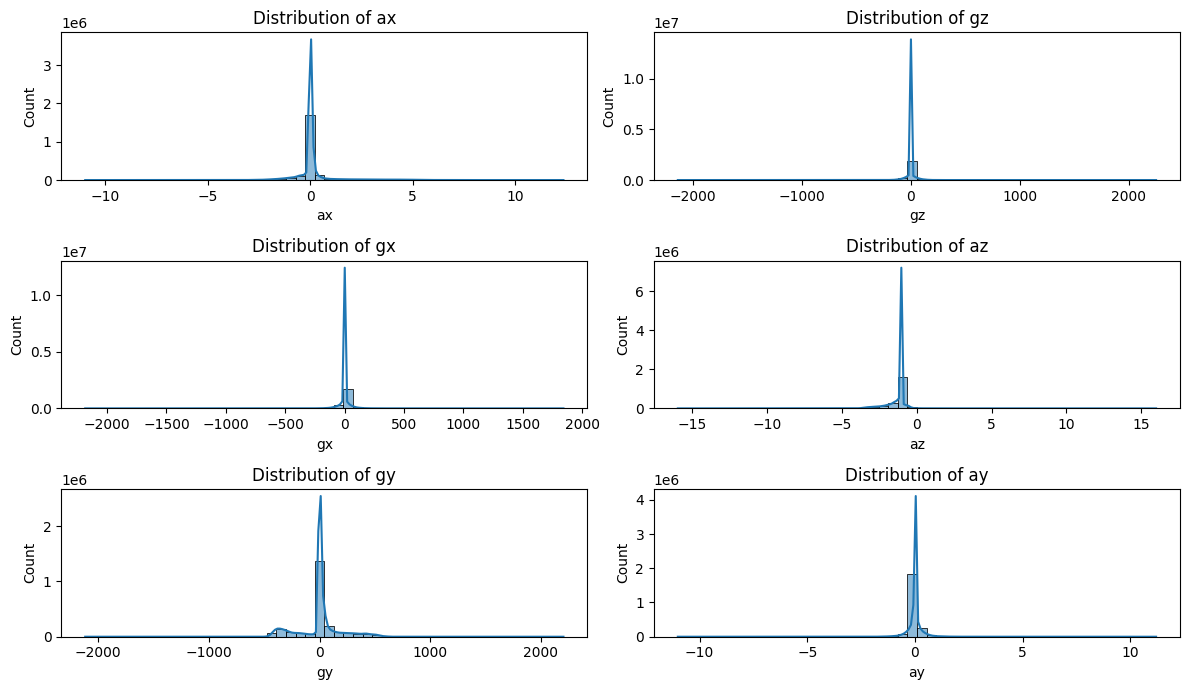

In [125]:
import seaborn as sns

sns.color_palette("rocket")
fig, axes = plt.subplots(3, 2, figsize=(12, 7))

axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, col in enumerate(columns_to_plot):
    sns.histplot(df[col], ax=axes[i], kde=True, bins=50).set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

The histogram shows the distribution is quite smooth (regular)

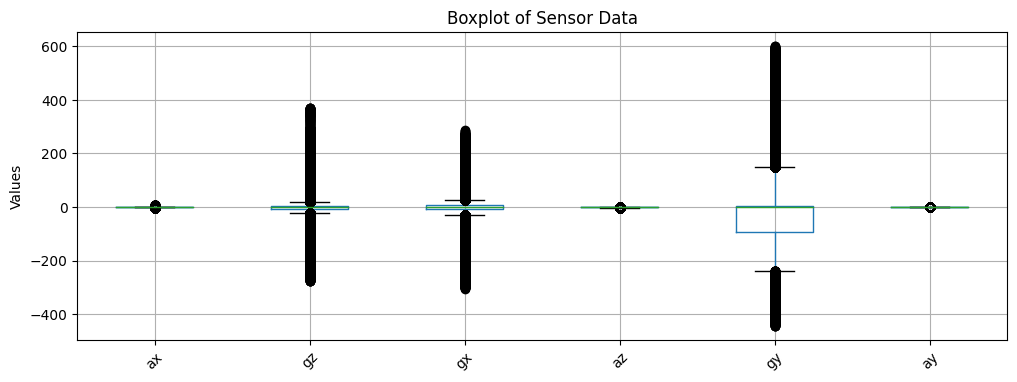

In [150]:
plt.figure(figsize=(12, 4))
df[columns_to_plot].boxplot()
plt.title("Boxplot of Sensor Data")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()

Outliers appear as points in gz gx and gy outside the whiskers, means potential noise. <br><br>
also means that there are more noise in gyroscope than accelerometer.

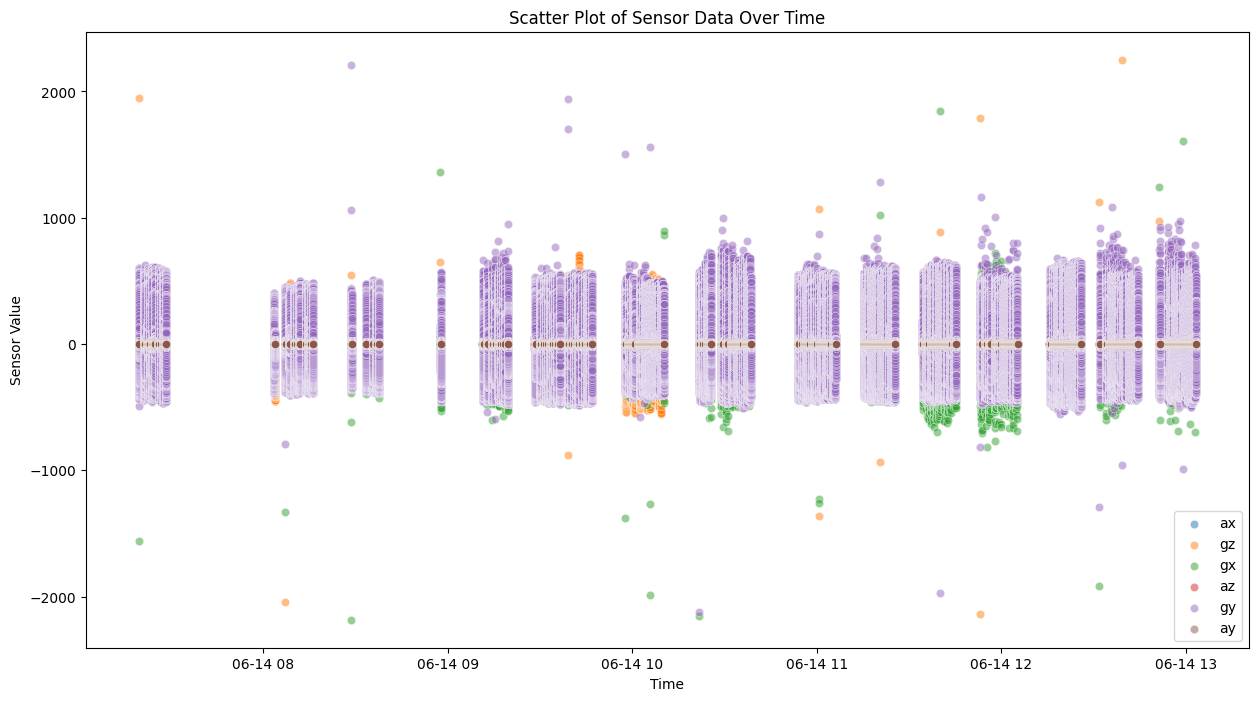

In [127]:
plt.figure(figsize=(15, 8))

# Use Seaborn's scatterplot for each sensor
for sensor in sensor_cols:
    sns.scatterplot(x=df.index, y=df[sensor], alpha=0.5, label=sensor)

plt.title("Scatter Plot of Sensor Data Over Time")
plt.xlabel("Time")
plt.ylabel("Sensor Value")
plt.legend()
plt.show()


#### Apply Noise Filtering (Low-Pass Butterworth Filter)
in the following code:
- Sampling Frequency (fs): From df.describe(), the average time difference is 0.00917 sec (≈9.17ms).
This corresponds to a sampling rate of ≈109 Hz (fs = 1 / 0.00917).
Using fs = 100 Hz (rounded for stability).

- Cutoff Frequency (cutoff): The std of gy (179) and gz (40) suggest high-frequency noise.
A cutoff frequency of 2.5 Hz is chosen (removes high-frequency noise but keeps trends).

- Filter Order (order = 4): Too high can cause distortion, too low might not filter enough.
order=4 is a good balance.
- nyquist = 0.5 * fs: Since we sample at fs=50 Hz, the Nyquist frequency is 25 Hz.
Any frequency above 25 Hz is lost due to the Nyquist theorem.

In [139]:
df.time_diff.mean()

0.009169068947406569

In [ ]:
from scipy.signal import butter, filtfilt

# Load your data (assuming df is already loaded)
fs = 100.0  # Sampling frequency (Hz)
cutoff = 2.5  # Cutoff frequency (Hz)
order = 4  # Filter order

def butter_lowpass_filter(data, cutoff, fs, order=4):
     # The Nyquist frequency is the maximum frequency we can capture based on the sampling rate.
     nyquist = 0.5 * fs  # Nyquist frequency
     # Normalizing the cutoff frequency ensures it's within the valid range [0,1] for the filter function.
     normal_cutoff = cutoff / nyquist  # Normalize cutoff
     b, a = butter(order, normal_cutoff, btype='low', analog=False)
     return filtfilt(b, a, data)

# Apply the filter to sensor data columns
filtered_df = df.copy()
sensor_columns = ["ax", "ay", "az", "gx", "gy", "gz"]

for col in sensor_columns:
     filtered_df[col] = butter_lowpass_filter(df[col], cutoff, fs, order)



#### Visualizing Before & After Filtering

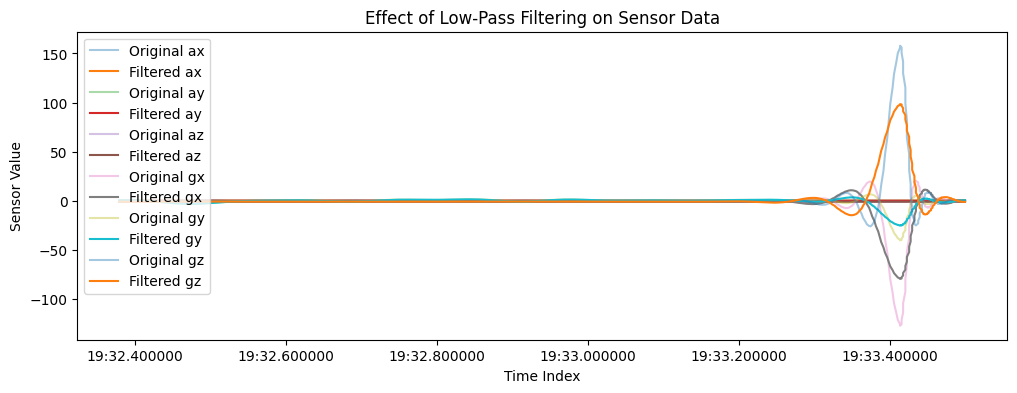

In [148]:
plt.figure(figsize=(12, 4))
for col in sensor_columns:
     plt.plot(df.index[:500], df[col][:500], alpha=0.4, label=f'Original {col}')
     plt.plot(df.index[:500], filtered_df[col][:500], label=f'Filtered {col}')
plt.xlabel("Time Index")
plt.ylabel("Sensor Value")
plt.title("Effect of Low-Pass Filtering on Sensor Data")
plt.legend()
plt.show()

As you can in the graph the values are getting smooth a little bit (check out the spikes between original and filtered)

In [145]:
filtered_df.describe()

,ax,gz,gx,az,gy,ay,time_diff
count,2.248628e+06,2.248628e+06,2.248628e+06,2.248628e+06,2.248628e+06,2.248628e+06,2.248627e+06
mean,1.200217e-01,-2.658855e-01,-4.722533e-01,-1.272025e+00,2.483511e-01,3.753519e-03,9.169069e-03
std,6.227705e-01,2.819690e+01,3.196942e+01,4.222818e-01,1.310447e+02,1.570025e-01,2.196743e+00
min,-2.246148e+00,-2.689279e+02,-2.742725e+02,-3.901363e+00,-4.407931e+02,-1.090997e+00,0.000000e+00
25%,-6.503511e-02,-7.226034e+00,-8.046268e+00,-1.482821e+00,-9.359933e+01,-2.504415e-02,1.000000e-03
50%,1.326400e-02,-3.780756e-01,-3.948044e-01,-1.063839e+00,2.366885e-01,2.288007e-03,1.000000e-03
75%,1.057819e-01,3.759453e+00,5.770688e+00,-1.009376e+00,4.497699e+00,4.073420e-02,2.000000e-03
max,5.292321e+00,3.681251e+02,2.536795e+02,3.389588e-01,5.722992e+02,1.692441e+00,2.097496e+03


### **Comparison of `df.describe()` vs. `filtered_df.describe()`**

#### **Key Observations**
| **Metric**  | **Before Filtering (`df.describe()`)**  | **After Filtering (`filtered_df.describe()`)** | **Impact** |
|------------|--------------------------------------|--------------------------------------|----------|
| **Standard Deviation (std)**  | Larger values across all columns | Reduced significantly (e.g., `gy` dropped from 179.04 to 131.04) | Less noise, smoother data |
| **Minimum (min)**  | Extreme negative values (e.g., `gz = -2137.73`) | Less extreme, closer to 0 (e.g., `gz = -268.93`) | Filtering removed extreme outliers |
| **Maximum (max)**  | Large peaks (e.g., `gy = 2205.98`) | Reduced significantly (`gy = 572.29`) | Removed extreme fluctuations |
| **25th & 75th Percentiles**  | Wider spread | More compressed | Less noise, but important variations might be removed |

---

#### **Interpretation**
1. **Reduced Noise & Smoother Data**  
   - The standard deviations (std) have decreased across all sensor readings.
   - This means less variation due to noise, making trends more visible.

2. **Extreme Outliers Removed**  
   - The min/max values show much **lower absolute values** after filtering.
   - Likely removed **sensor spikes or incorrect readings**.

3. **Possible Loss of Important Variations?**  
   - The 25th-75th percentile range is narrower, meaning small fluctuations may have been lost.
   - If too much filtering was applied, **some real sensor activity might be removed**.

---

#### **Are These Good Changes?**
✅ **Yes, the changes are mostly beneficial**:  
- The data is **smoother**, with fewer extreme spikes and outliers.
- Standard deviation is lower, meaning **more stable** readings.
  


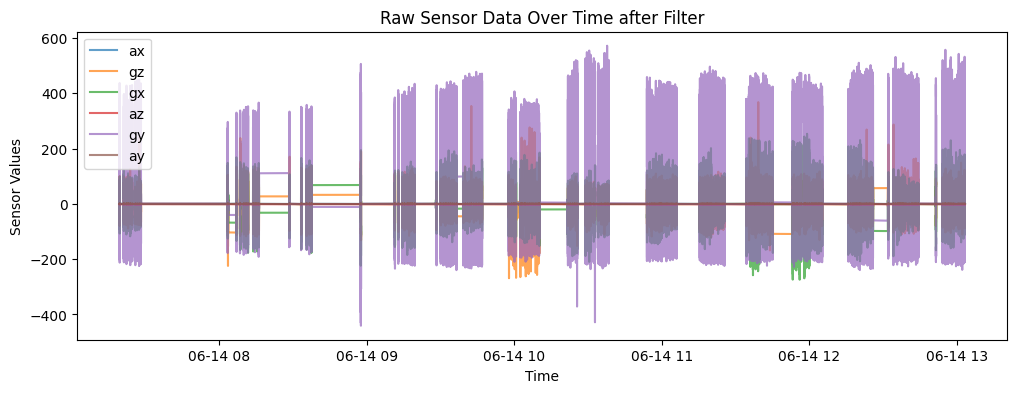

In [149]:
# Plot multiple sensor values
columns_to_plot = ['ax', 'gz', 'gx', 'az', 'gy', 'ay']
plt.figure(figsize=(12, 4))

for col in columns_to_plot:
    plt.plot(filtered_df.index, filtered_df[col], label=col, alpha=0.7)  # Transparency for overlapping

plt.xlabel("Time")
plt.ylabel("Sensor Values")
plt.title("Raw Sensor Data Over Time after Filter")
plt.legend()
plt.show()

As you can see the irregular spikes are gone

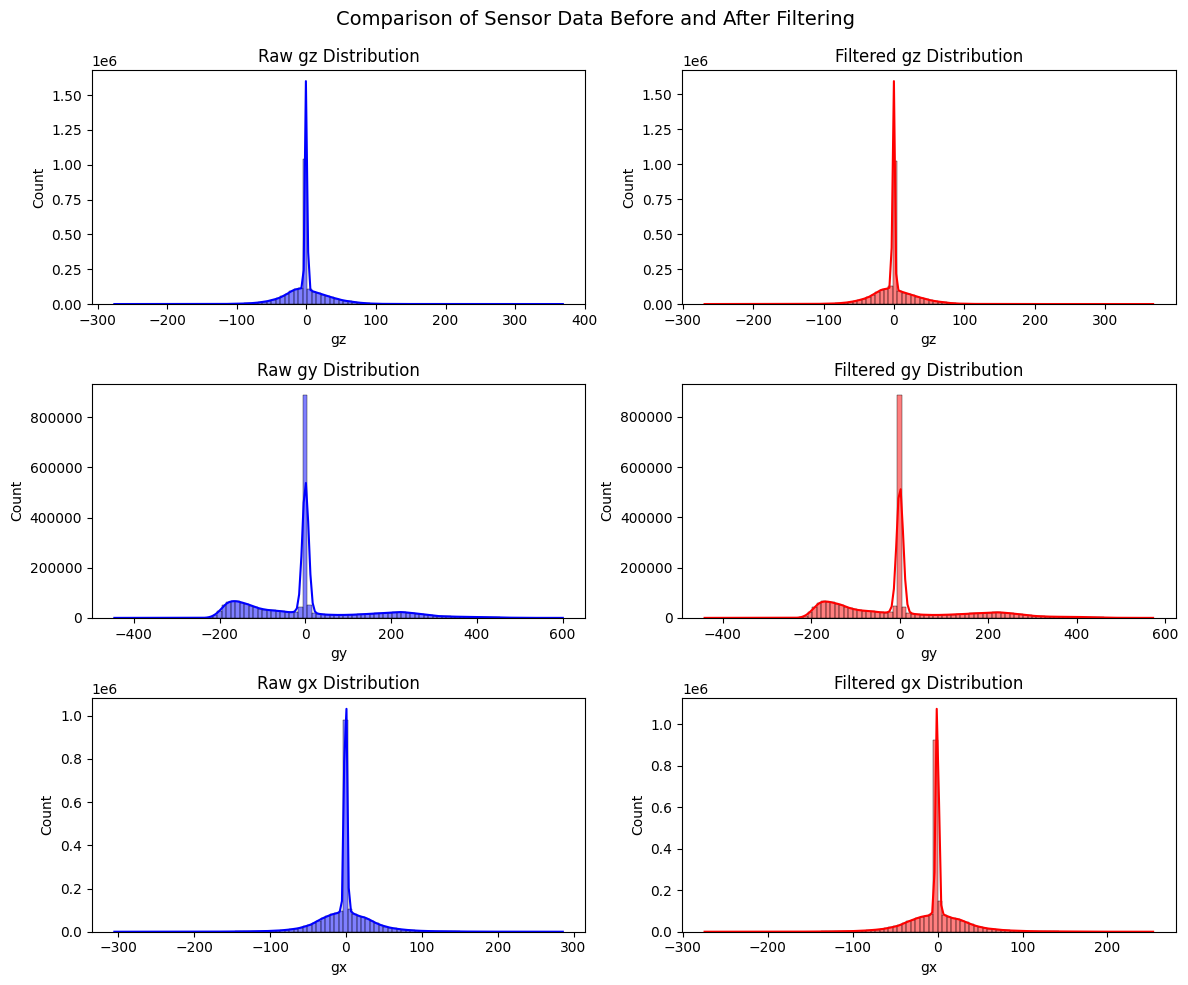

In [146]:
# Lets compare a few columns
columns_to_plot = ['gz', 'gy', 'gx']

fig, axes = plt.subplots(len(columns_to_plot), 2, figsize=(12, 10))
fig.suptitle('Comparison of Sensor Data Before and After Filtering', fontsize=14)

for i, col in enumerate(columns_to_plot):
    # Raw data distribution
    sns.histplot(df[col], bins=100, kde=True, ax=axes[i, 0], color='blue')
    axes[i, 0].set_title(f'Raw {col} Distribution')
    
    # Filtered data distribution
    sns.histplot(filtered_df[col], bins=100, kde=True, ax=axes[i, 1], color='red')
    axes[i, 1].set_title(f'Filtered {col} Distribution')
    
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [147]:
# to save the raw extracted data
path_to_save = os.path.join('../data', 'preprocessed_data.csv')
filtered_df.to_csv(path_to_save)